# Final Project: Street Sweeping Schdule - Mengting Cai

# Data Extraction


In [34]:
#Reference: Data from
#https://data.boston.gov/dataset/street-sweeping-schedules/resource/9fdbdcad-67c8-4b23-b6ec-861e77d56227
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.charts import BoxPlot
from bokeh.layouts import column,row
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
import statsmodels.api as sm
import statsmodels.formula.api as smf
output_notebook()
%matplotlib inline


Loading BokehJS ...

## Insert Data

In [ ]:
URL = "https://data.boston.gov/dataset/00c015a1-2b62-4072-a71e-79b292ce9670/resource/9fdbdcad-67c8-4b23-b6ec-861e77d56227/download/street-sweeping-schedules.csv"
URL_Read = pd.read_csv(URL)

In [2]:
df = pd.read_csv('D:/ALY6983/Final/street-sweeping-schedules.csv')
df.head()

,MainID,CrossStreetMainID,Street,from,to,District,StartTime,EndTime,Side,Miles,...,week5,EveryDay,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Yearround
0,1,1222.0,Ackley Pl,Washington St,Dead End,2,08:00:00.0000000,12:00:00.0000000,Even,0.0455,...,False,False,True,False,False,False,False,False,False,False
1,2,545.0,Arcadia Park,Draper St,Ditson St,3,08:00:00.0000000,12:00:00.0000000,Even,0.0835,...,False,False,False,False,False,True,False,False,False,False
2,3,1677.0,Ashcroft St,Perkins St,Moraine St,2,08:00:00.0000000,12:00:00.0000000,Odd,0.1015,...,False,False,False,False,True,False,False,False,False,False
3,4,2635.0,Boylston St,Tremont St,Charles St,1B,00:01:00.0000000,07:00:00.0000000,NaN,0.1519,...,True,True,True,True,True,True,True,True,True,True
4,5,674.0,Chestnut St,Walnut St,Charles St,1H,08:00:00.0000000,12:00:00.0000000,Even,0.2008,...,False,False,False,False,False,False,True,False,False,False


In [3]:
# Get the Info of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3392 entries, 0 to 3391
Data columns (total 25 columns):
MainID               3392 non-null int64
CrossStreetMainID    3147 non-null float64
Street               3392 non-null object
from                 3389 non-null object
to                   3389 non-null object
District             3389 non-null object
StartTime            3392 non-null object
EndTime              3392 non-null object
Side                 3185 non-null object
Miles                3392 non-null float64
oneway               3392 non-null bool
week1                3392 non-null bool
week2                3392 non-null bool
week3                3392 non-null bool
week4                3392 non-null bool
week5                3392 non-null bool
EveryDay             3392 non-null bool
Monday               3392 non-null bool
Tuesday              3392 non-null bool
Wednesday            3392 non-null bool
Thursday             3392 non-null bool
Friday               3392 non-nu

## The Answers I want to find out:

1. Which street is the shortest street and which is the longest one which need to be swept?

2. From Monday to Sunday,which day's sweep amounts is the most, and which is the least?

3. Will the busy streets have more frequent sweeps? 

4. From the regression graph,what can I find out. 


# Data Cleanup


In [4]:
# Missing Value Handling
n_df = df.shape[0]
cols = df.columns.tolist()
for col in cols:
    missing = n_df - np.count_nonzero(df[col].isnull().values)
    mis_perc = 100 - float(missing)/n_df*100
    print("{col} miss: {miss}%".format(col=col,miss=mis_perc))

MainID miss: 0.0%
CrossStreetMainID miss: 7.222877358490564%
Street miss: 0.0%
from miss: 0.08844339622640973%
to miss: 0.08844339622640973%
District miss: 0.08844339622640973%
StartTime miss: 0.0%
EndTime miss: 0.0%
Side miss: 6.102594339622641%
Miles miss: 0.0%
oneway miss: 0.0%
week1 miss: 0.0%
week2 miss: 0.0%
week3 miss: 0.0%
week4 miss: 0.0%
week5 miss: 0.0%
EveryDay miss: 0.0%
Monday miss: 0.0%
Tuesday miss: 0.0%
Wednesday miss: 0.0%
Thursday miss: 0.0%
Friday miss: 0.0%
Saturday miss: 0.0%
Sunday miss: 0.0%
Yearround miss: 0.0%


In [5]:
# Clean Missing Value
dfnonull = df.dropna(axis=0,how='any')

In [29]:
# Selecting subset of relevant columns
df2 = dfnonull[["Street","from","to","Miles","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
df2.head()

,Street,from,to,Miles,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,Ackley Pl,Washington St,Dead End,0.0455,True,False,False,False,False,False,False
1,Arcadia Park,Draper St,Ditson St,0.0835,False,False,False,True,False,False,False
2,Ashcroft St,Perkins St,Moraine St,0.1015,False,False,True,False,False,False,False
4,Chestnut St,Walnut St,Charles St,0.2008,False,False,False,False,True,False,False
5,Blackwood St,St Botolph St,Dead End,0.0517,False,False,False,False,True,False,False


In [7]:
# Clean Duplicated Data
df3 = df2.drop_duplicates(keep='first')

# Detecting outliers
df3.describe()

,Miles
count,1657.000000
mean,0.254358
std,0.332020
min,-0.090300
25%,0.090300
50%,0.158000
75%,0.272700
max,4.764400


In [8]:
# Replace outliers & Sort Data by Street Name from A to Z
df4 = df3.replace([0,-0.090300],df3['Miles'].mean()).sort_values(by=['Street'])
df4.head()

,Street,from,to,StartTime,EndTime,Miles,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
55,A St,Melcher St,Congress St,13:00:00.0000000,17:00:00.0000000,0.1030,False,False,False,False,True,False,False
321,A St,Binford St,Congress St,13:00:00.0000000,17:00:00.0000000,0.2720,False,False,False,False,True,False,False
10,Abbotsford St,Walnut Ave,Harold St,08:00:00.0000000,12:00:00.0000000,0.1210,False,False,False,False,True,False,False
7,Acadia St,East First St,East Second St,09:00:00.0000000,13:00:00.0000000,0.0568,False,False,False,False,True,False,False
0,Ackley Pl,Washington St,Dead End,08:00:00.0000000,12:00:00.0000000,0.0455,True,False,False,False,False,False,False


# Data Visualization


In [9]:
# Change all value in "bool" to "int".

for u in df4.columns:
    if df4[u].dtype==bool:
        df4[u]=df4[u].astype('int')
df4.head()

,Street,from,to,StartTime,EndTime,Miles,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
55,A St,Melcher St,Congress St,13:00:00.0000000,17:00:00.0000000,0.1030,0,0,0,0,1,0,0
321,A St,Binford St,Congress St,13:00:00.0000000,17:00:00.0000000,0.2720,0,0,0,0,1,0,0
10,Abbotsford St,Walnut Ave,Harold St,08:00:00.0000000,12:00:00.0000000,0.1210,0,0,0,0,1,0,0
7,Acadia St,East First St,East Second St,09:00:00.0000000,13:00:00.0000000,0.0568,0,0,0,0,1,0,0
0,Ackley Pl,Washington St,Dead End,08:00:00.0000000,12:00:00.0000000,0.0455,1,0,0,0,0,0,0


In [10]:
# Pick Street and Miles for the First Visualization

df_miles = df4[["Street","Miles"]]
df_miles.head()

,Street,Miles
55,A St,0.1030
321,A St,0.2720
10,Abbotsford St,0.1210
7,Acadia St,0.0568
0,Ackley Pl,0.0455


In [11]:
# Get the Total Miles of the Streets

combine=df_miles['Miles'].groupby(df_miles['Street'])
combine_sum = combine.sum()
df_combine_sum = pd.DataFrame(combine_sum)
df_combine_sum.sort_values(by=['Miles']).head()

,Miles
Street,
Fiske Ter,0.0218
Manton Ter,0.0223
Wiggin St,0.0225
Greenwich Ct,0.0225
Feneno Ter,0.0229


In [37]:
# Generate the vbar of the Street Length by Bokeh

street = df_combine_sum.index.tolist()
miles = df_combine_sum['Miles'].tolist()
source = ColumnDataSource(dict(street=street, miles=miles))
p = figure(x_range=street,y_range=(0,25), plot_height=850,plot_width=900, 
           title="The Length of the Street Cleaned",
           x_axis_label = "Street Name",
           y_axis_label = "Street Length (mile)")

p.vbar(x="street",top="miles",width=1, source=source)
show(p)

In [13]:
df_wk = df4[["Street","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
T1 = df4['Monday'].sum()
print("Monday:", T1)
T2 = df4['Tuesday'].sum()
print("Tuesday:", T2)
T3 = df4['Wednesday'].sum()
print("Wednesday:", T3)
T4 = df4['Thursday'].sum()
print("Thursday:", T4)
T5 = df4['Friday'].sum()
print("Friday:", T5)
T6 = df4['Saturday'].sum()
print("Saturday:", T6)
T7 = df4['Sunday'].sum()
print("Sunday:", T7)

Monday: 284
Tuesday: 277
Wednesday: 444
Thursday: 480
Friday: 352
Saturday: 46
Sunday: 46


In [32]:
df_day = pd.DataFrame([{'Day':'Monday','Count':T1},{'Count':T2,'Day':'Tuesday'},{'Count':T3,'Day':'Wednesday'},
                     {'Count':T4,'Day':'Thursday'},{'Count':T5,'Day':'Friday'},{'Count':T6,'Day':'Saturday'},
                     {'Count':T7,'Day':'Sunday'}])
df_day
df_day.reindex(columns=['Day','Count'])

,Day,Count
0,Monday,284
1,Tuesday,277
2,Wednesday,444
3,Thursday,480
4,Friday,352
5,Saturday,46
6,Sunday,46


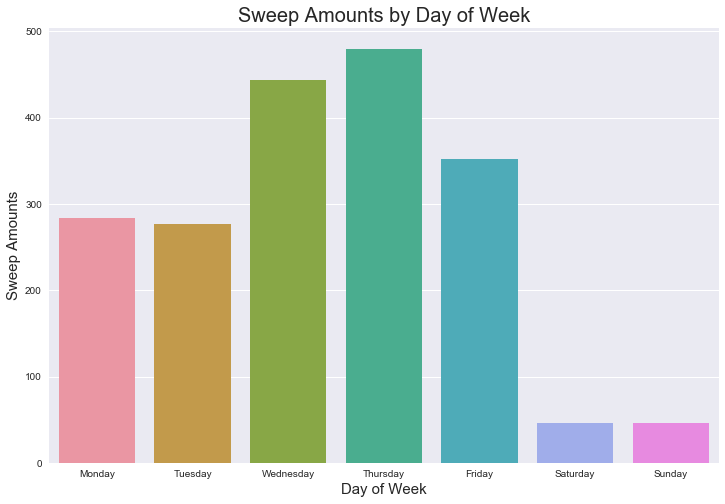

In [33]:
# Generate a bar plot that shows Sweep Amounts by day of week
plt.figure(figsize=(12,8))
sns.barplot(x="Day",y='Count',data=df_day).set_title('Sweep Amounts by Day of Week',fontsize= 20)
plt.xlabel('Day of Week',fontsize= 15)
plt.ylabel('Sweep Amounts',fontsize= 15)

In [16]:
# Get the total sweep amount for each street in the day of week.
df_day = df_wk.groupby('Street').sum()
df_day.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Street,,,,,,,
A St,0,0,0,0,2,0,0
Abbotsford St,0,0,0,0,1,0,0
Acadia St,0,0,0,0,1,0,0
Ackley Pl,1,0,0,0,0,0,0
Adams St,0,1,2,4,0,0,0


In [17]:
# Add a Sum column to sum up the total sweep amount for each day in one week  
df_day['Sum']=df_day['Monday']+ df_day['Tuesday']+df_day['Wednesday']+df_day['Thursday']+df_day['Friday']+df_day['Saturday']+df_day['Sunday']

# Add the Miles columns
df_day['Miles']=df_combine_sum['Miles']

# Drop a wrong column
df_day.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Sum,Miles
Street,,,,,,,,,
A St,0,0,0,0,2,0,0,2,0.3750
Abbotsford St,0,0,0,0,1,0,0,1,0.1210
Acadia St,0,0,0,0,1,0,0,1,0.0568
Ackley Pl,1,0,0,0,0,0,0,1,0.0455
Adams St,0,1,2,4,0,0,0,7,1.2381


In [28]:
df_day.sort_values('Sum').tail()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Sum,Miles
Street,,,,,,,,,
Belvidere St,2,2,2,2,2,2,2,14,0.2955
Boylston St,4,2,2,2,2,2,2,16,1.7100
Washington St,1,13,12,2,7,1,1,37,22.8499
Summer St,6,6,6,6,7,6,6,43,2.8383
Massachusetts Ave,7,7,8,7,8,7,7,51,10.5007


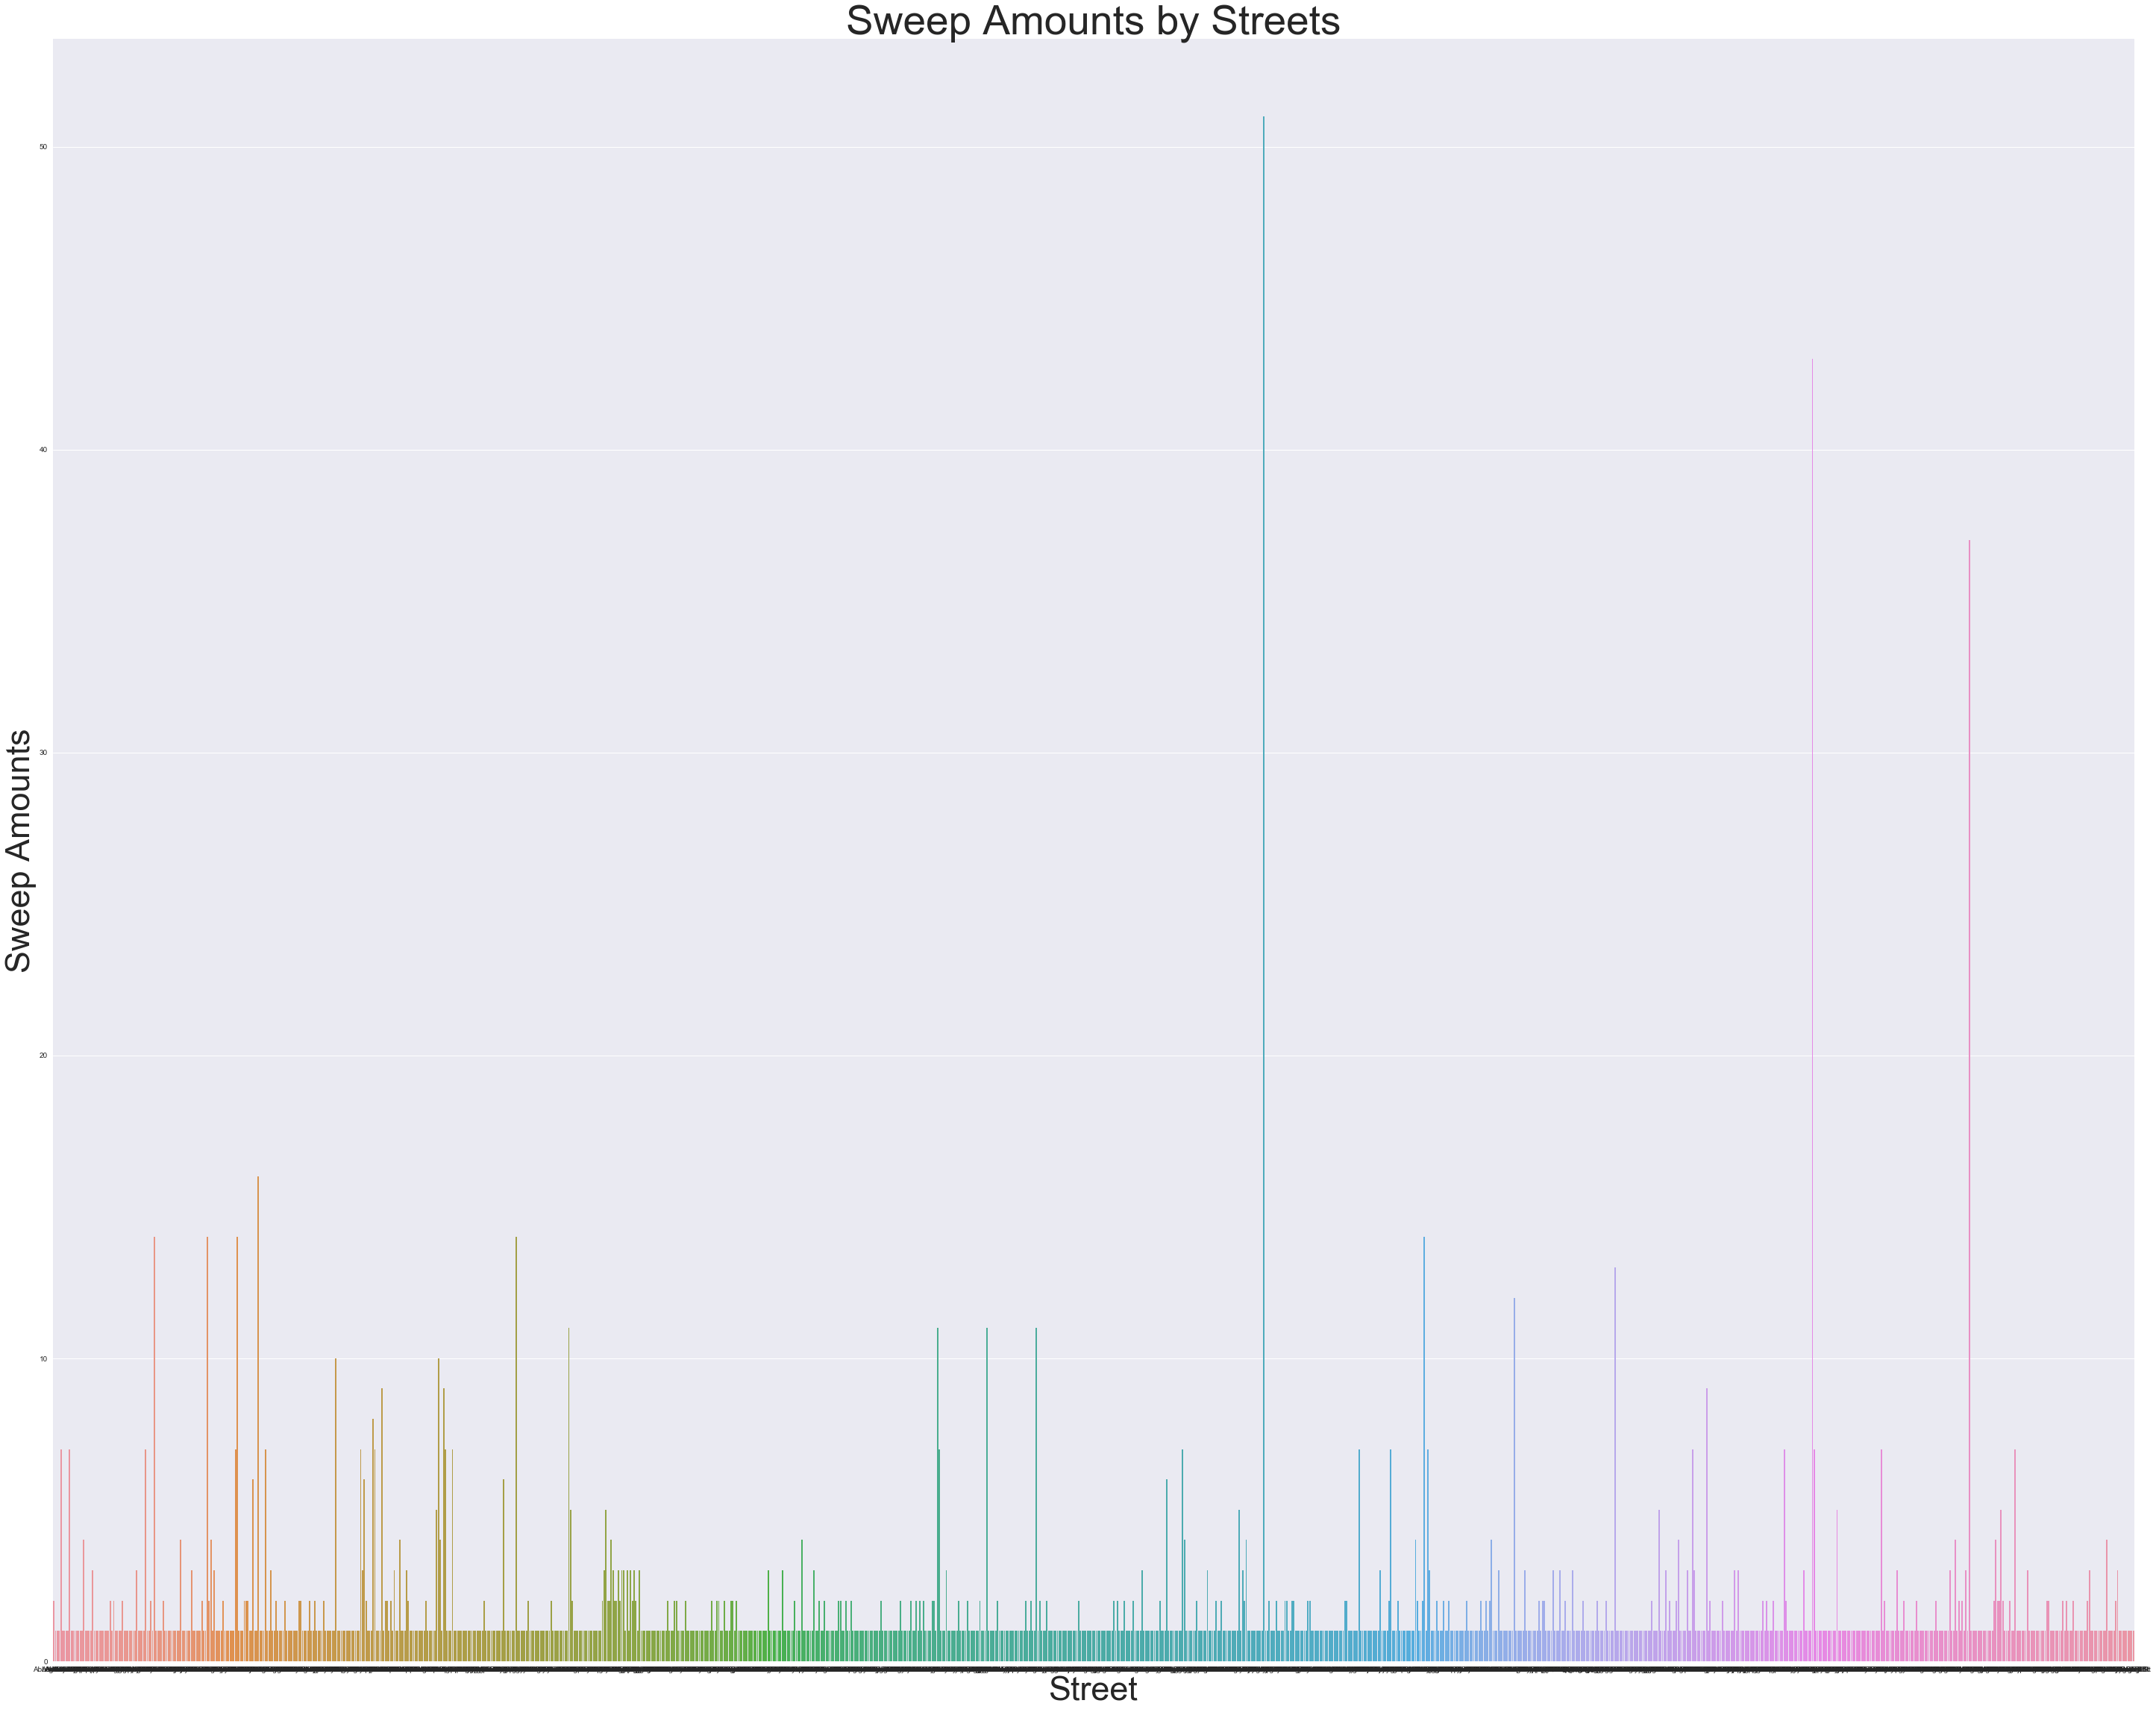

In [18]:
plt.figure(figsize=(50,40))
sns.barplot(x=df_day.index,y="Sum",data=df_day).set_title('Sweep Amounts by Streets',fontsize= 55)
plt.xlabel('Street',fontsize= 45)
plt.ylabel('Sweep Amounts',fontsize= 45)

# Predictive Analytics

## Statsmodels

In [19]:
results = smf.ols('Sum~Miles',data = df_day).fit()
print(results.params)
results.summary()

Intercept    1.075827
Miles        1.555097
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Sum   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     835.9
Date:                Fri, 30 Mar 2018   Prob (F-statistic):          2.39e-139
Time:                        12:06:40   Log-Likelihood:                -2527.2
No. Observations:                1180   AIC:                             5058.
Df Residuals:                    1178   BIC:                             5069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0758      0.063     17.061      0.000       0.952       1.200
Miles          1.5551      0.054     28.913      0.000       1.450       1.661
==============================================================================
Omnibus:                     1861.373   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1317412.533
Skew:                           9.416   Prob(JB):                         0.00
Kurtosis:                     165.604   Cond. No.                         1.43
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression

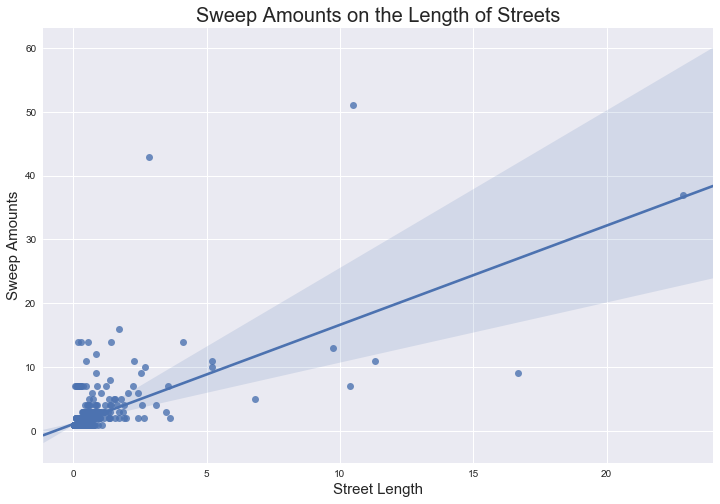

In [20]:
# Regression Plot by Seaborn

plt.figure(figsize=(12,8))
sns.regplot(x="Miles",y="Sum",data=df_day).set_title('Sweep Amounts on the Length of Streets',fontsize= 20)
plt.xlabel('Street Length',fontsize= 15)
plt.ylabel('Sweep Amounts',fontsize= 15)

# Conclusion

The dataset that I selected is the street sweeping schedules report from ANALYZE BOSTON website. This dataset contains 25 columns. There are a lot of main information in this dataset. They are the name of the street sweeping area, work start and end time, miles, and schedule for every week and day. It is a big dataset which memory usage is more than 314.8 KB. 

The reason why I choose this dataset is I once watched a public service advertisement. It said that the sanitation workers started to work every morning and night for the cleanliness of a city. The advertisement urges us to care for these people. I want to use this dataset to understand basic information about the sanitation work of a city. At the same time, I want to understand the frequency of cleanliness of cities in cities like Boston.

Here are the answers I found from the project:

1. Fiske Ter is the shortest street and the Washington St is the longest street which need to be swept.

2. From Monday to Sunday,Thursday's sweep days are the most, and in the weekend,the sweep amounts are the least.

3. The busy streets, such as Summer St, Massachusetts Ave, have more frequent sweeps. 

4. From the regression graph,we can say that the sweep amounts are related the length of streets like Washington St. 

5. However, there are some outliers showed in the graph like Summer St and Massachusetts Ave. 
  They are not very long, but have more frequency sweep times. 

To sum up, for cities like Boston, this frequency and number of sweeps should be up to the mark. But I personally think that, some streets' sweep schdule is not reasonable. For example, the Belvidere St which is only 0.2955 miles long, its sweep amounts in one week is 14. It is too much for this street. Therefore, I think this Current Street Sweep Schedule has to be adjusted.

